In [12]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import signal
import os
from scipy.interpolate import griddata
os.chdir('/home/jiarong/research/05.17/pressure_m0.1B0Ustar0.8ak0.1Bo200Re100000.')

def put_together(nodes, filename):
    ''' This function serves to put data from different nodes together.
        Input: the number of nodes, filename
        Output: a concatenated matrix.
    '''
    pid_set = np.arange(0, nodes)
    li = []
    for pid in pid_set:
        df = pd.read_csv(filename + '_%d' % pid, delimiter = ',', header=0, names = ['x', 'y', 'p', 'p_air'])
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True, sort=True)
    return frame   

from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ''' This function serves to generate the color bar.'''
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

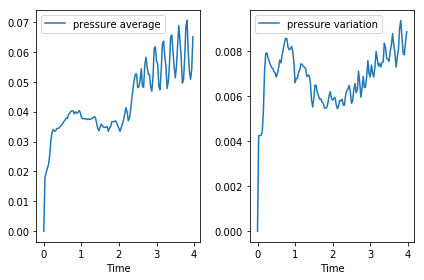

In [13]:
'''
    This is for showing the trend in pressure average and variation.
'''
N = 128 ; nodes = 16
t = np.zeros(N)
p_aver = np.zeros(N)
p_var = np.zeros(N)

for i in range(1, N):
    t[i] = i*1./32
    filename = "./pressure_direct%g" % t[i]
    pressure = put_together(nodes, filename)
#     pressure = pressure.apply(pd.to_numeric)
    p_air = np.array(pd.to_numeric(pressure.iloc[:,3]))
    p_aver[i] = np.average(p_air)
    p_var[i] = np.var(p_air)
    
fig, (ax1, ax2) = plt.subplots(ncols=2)    
img1 = ax1.plot(t, p_aver, label = 'pressure average')
img2 = ax2.plot(t, p_var, label = 'pressure variation')
ax1.legend() ; ax1.set_xlabel('Time')
ax2.legend() ; ax2.set_xlabel('Time')
plt.tight_layout(h_pad=1)   

In [14]:
'''
    This is for showing the trend in pressure average and variation.
    From dump file output.
'''

N = 1*32      # how many cycles 
t = np.zeros(N)
p_aver = np.zeros(N)
p_var = np.zeros(N)

for i in range(1, N):
    t[i] = i*1./32
    filename = "./field_direct%g" % t[i]
    pressure = pd.read_csv(filename, delimiter = ',', header=0)
    p_air = np.array(pd.to_numeric(pressure.iloc[:,3]))
    p_aver[i] = np.average(p_air)
    p_var[i] = np.var(p_air)
    
fig, (ax1, ax2) = plt.subplots(ncols=2)    
img1 = ax1.plot(t, p_aver, label = 'pressure average')
img2 = ax2.plot(t, p_var, label = 'pressure variation')
ax1.legend() ; ax1.set_xlabel('Time')
ax2.legend() ; ax2.set_xlabel('Time')
plt.tight_layout(h_pad=1)   

FileNotFoundError: File b'./field_direct0.625' does not exist

FileNotFoundError: File b'./eta0.625' does not exist

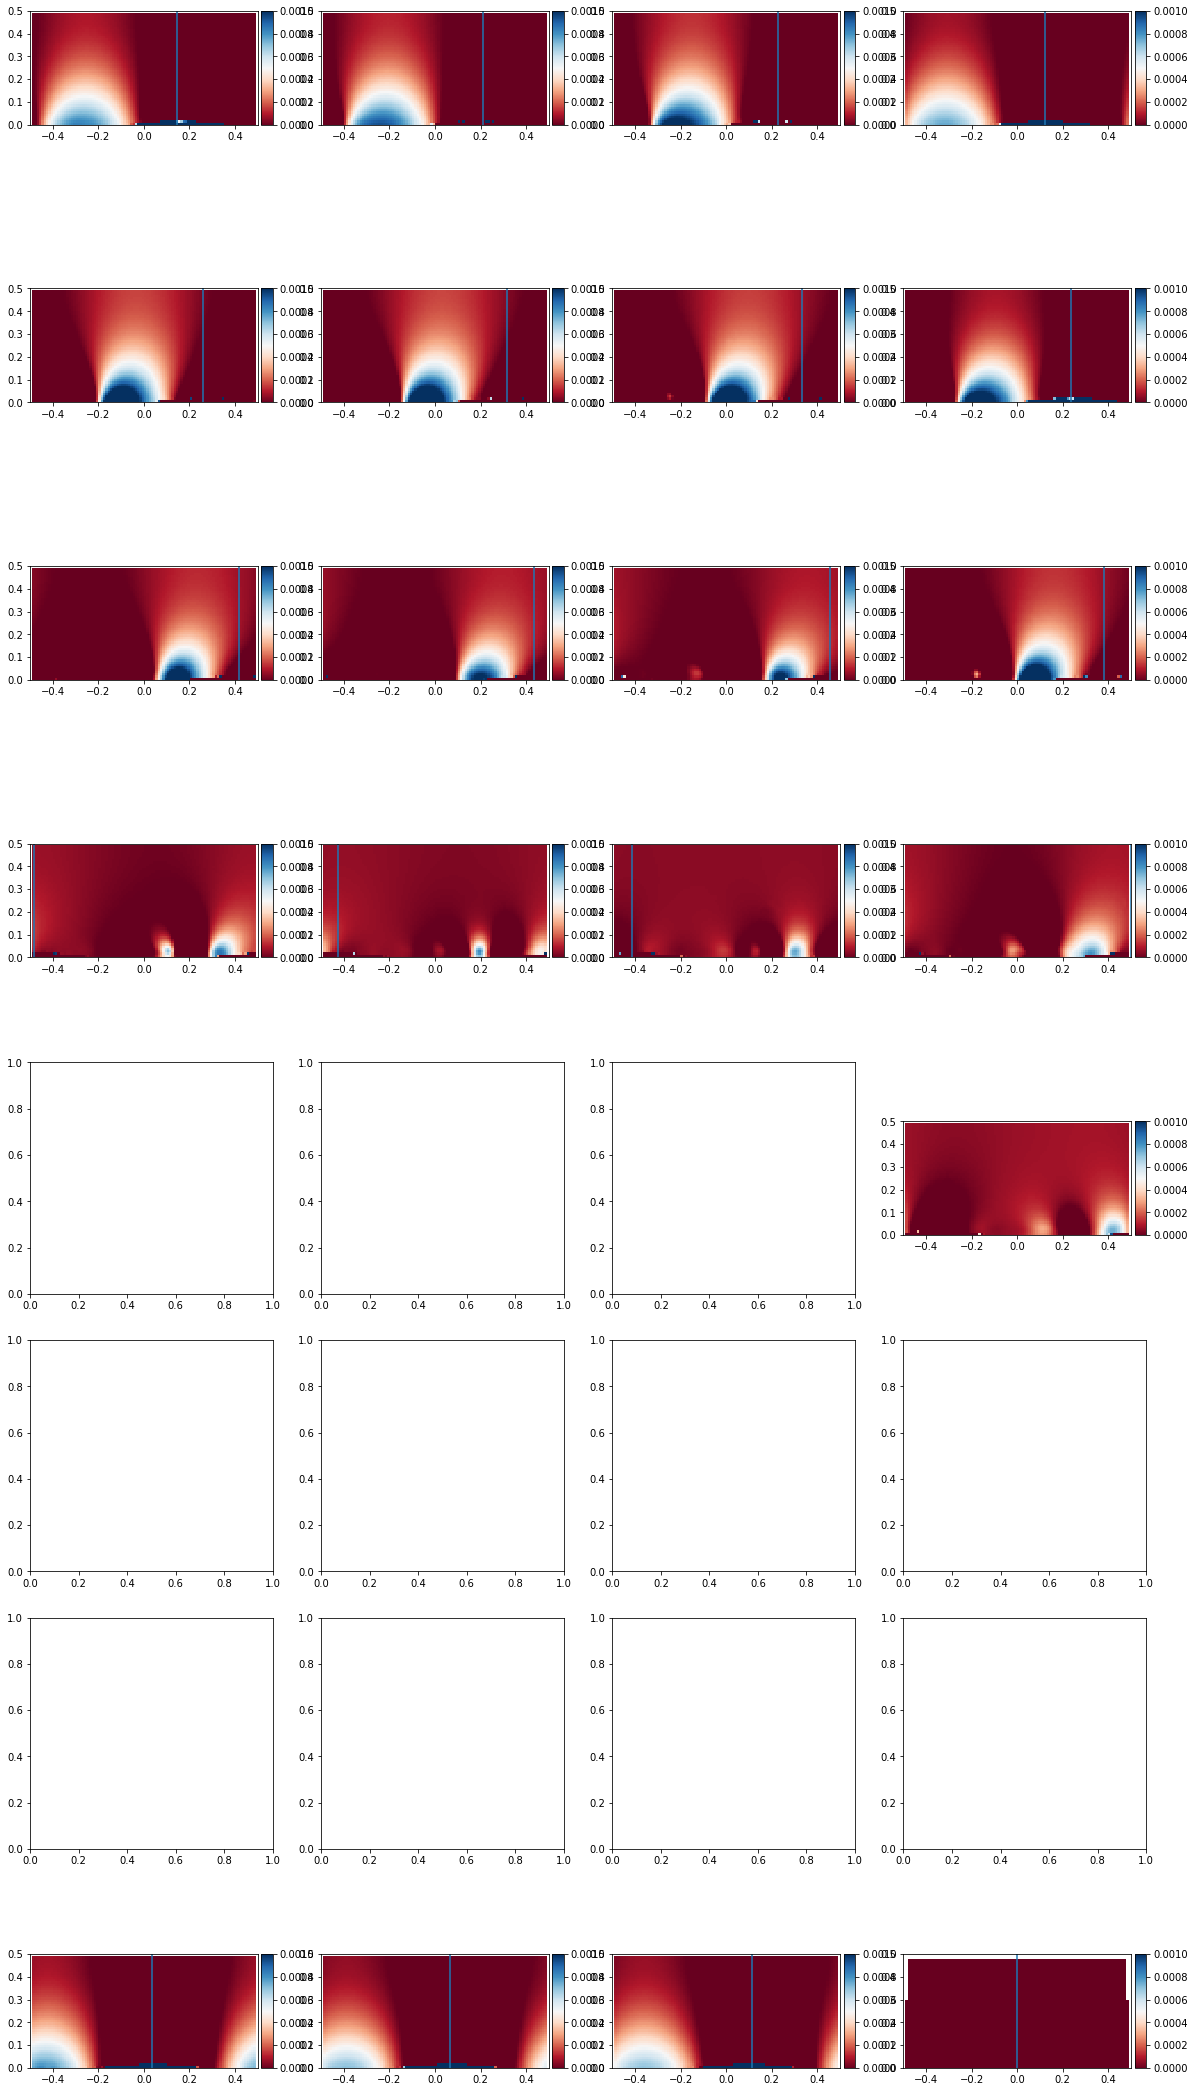

In [7]:
'''
    This is for parallel output. 
    Pressure are plotter from direct output.
'''
fig, ax = plt.subplots(ncols=4, nrows=8, figsize = [20, 40])   
N = 32; delta = 1; ncols = 4
nodes = 16
i_set = np.arange(0, N)
for i in i_set:
    t[i] = i*1./32
    filename = "./pressure_direct%g" % t[i]
# Store configuration file values
    pressure = put_together(nodes, filename)
    pressure = pressure.apply(pd.to_numeric)
    grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
    grid_p = griddata((pressure.x, pressure.y), pressure.p_air, (grid_x, grid_y), method='cubic')
#     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].contour(grid_x, grid_y, grid_p)
#     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(grid_p.T, vmin=0, extent=(-0.5,0.5,-0.5,0.5))
    A, B = np.split(grid_p.T, 2)
    B = B - np.nanmean(B)
    img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(B, extent=(-0.5,0.5,0,0.5), vmin=0, vmax=0.001, cmap='RdBu', origin='lower')
#     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(grid_p.T, origin='lower', vmin=-0.004, vmax=0.004, extent=(-0.5,0.5,-0.5,0.5))
    colorbar(img) 

    # plot the crest position
    filename = "./eta%g" % t[i]
    eta = pd.read_table(filename, delimiter = ',')
    eta_sorted = eta.sort_values(by = ['x'])
    crest = np.array(eta[eta['eta']==eta['eta'].max()].x)
    x_crest = np.average(crest)
    x = x_crest*np.ones(100)
    y = np.linspace(0, 0.5, 100, endpoint=True)
    ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].plot(x, y)
  
st = fig.suptitle('From t = 0 to T, every 1/32 T')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
st.set_y(0.95)
plt.show()

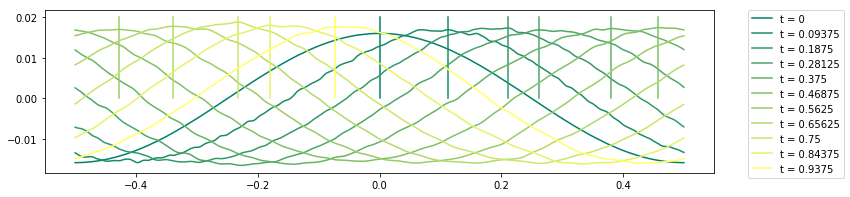

In [11]:
'''
    Sanitor check for elevation shape.
'''  
fig = plt.figure(figsize = [12, 3])
N = 32; delta = 3; 
color_idx = np.linspace(0, 1, N//delta+1)
for i in range(0, N, delta):   
    # plot the elevation
    filename = "./eta%g" % t[i]
    exists = os.path.exists(filename)
    if exists:
        eta = pd.read_table(filename, delimiter = ',')
        eta_sorted = eta.sort_values(by = ['x'])
        plt.plot(eta_sorted.x, eta_sorted.eta, label = 't = %g' %t[i], color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))
        crest = np.array(eta[eta['eta']==eta['eta'].max()].x)
        x_crest = np.average(crest)
        x = x_crest*np.ones(100)
        y = np.linspace(0, 0.02, 100, endpoint=True)
        plt.plot(x, y, color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

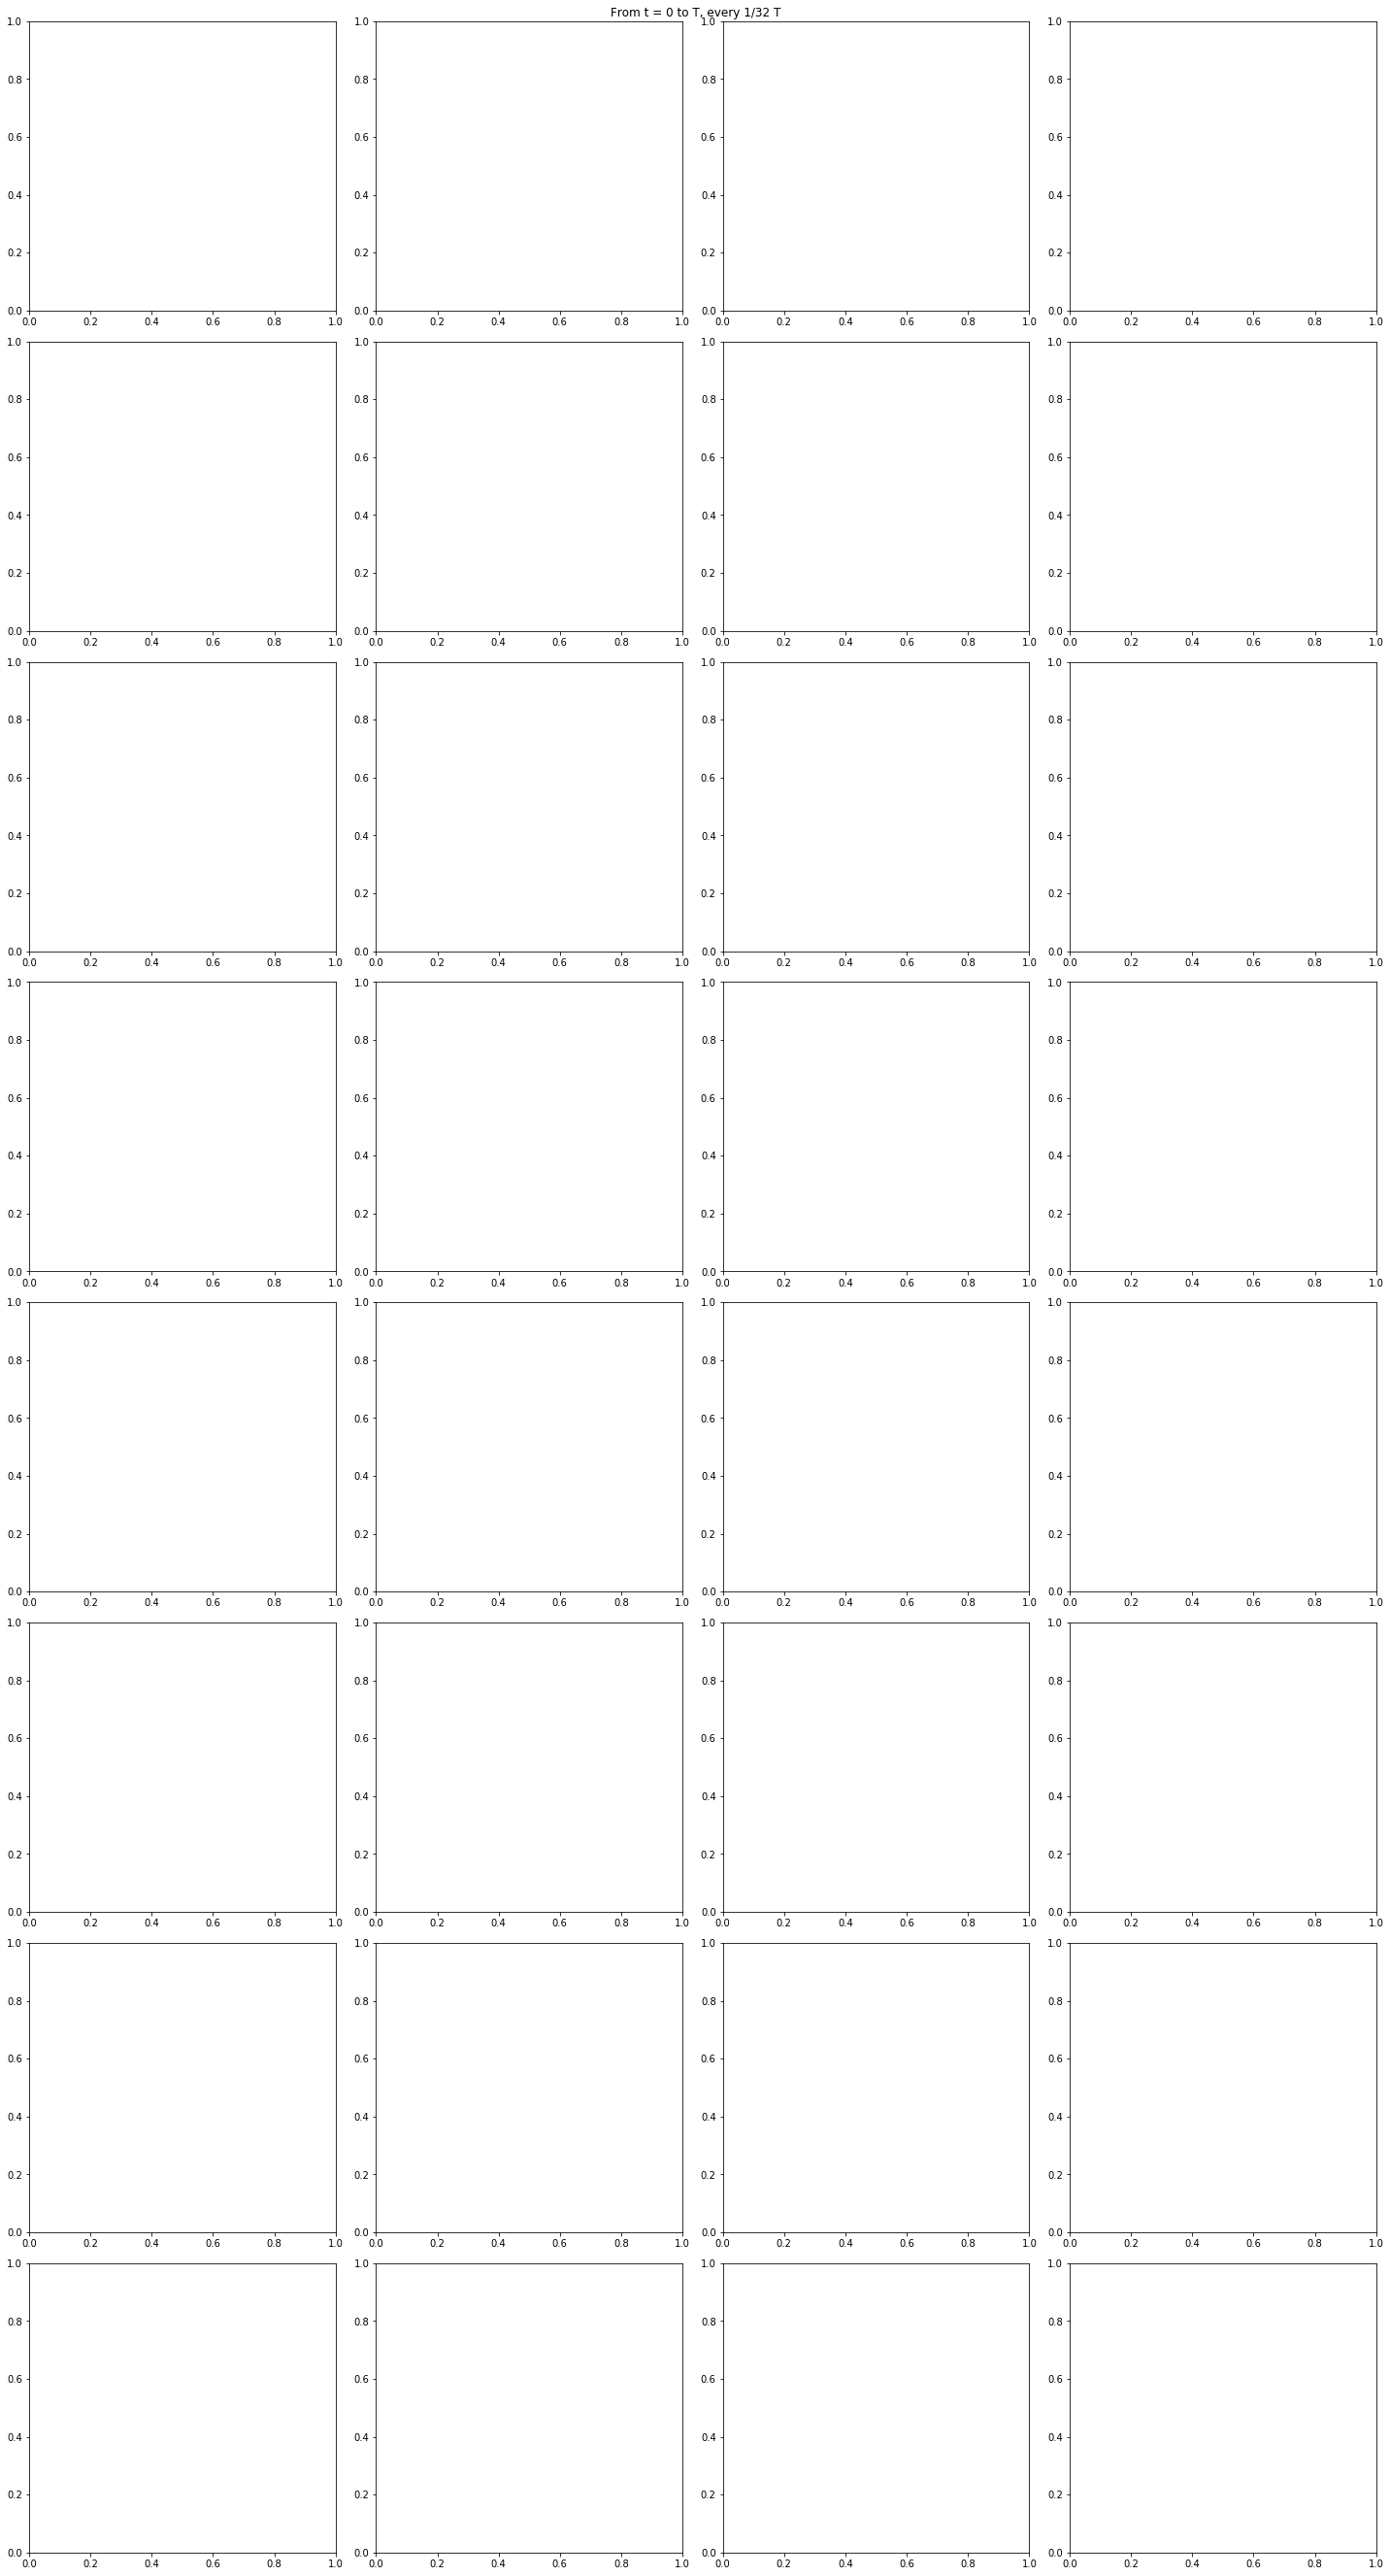

In [5]:
'''
    This is for parallel output. 
    Pressure are plotter from dump files.
'''
fig, ax = plt.subplots(ncols=4, nrows=8, figsize = [20, 40])   
N = 32; delta = 1; ncols = 4
nodes = 16
i_set = np.arange(0, N)
for i in i_set:
    t[i] = i*1./32
    filename = "./pressure_direct%g" % t[i]
    exists = os.path.exists(filename)
    if exists:
    # Store configuration file values
        pressure = put_together(nodes, filename)
        pressure = pressure.apply(pd.to_numeric)
        grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
        grid_p = griddata((pressure.x, pressure.y), pressure.p_air, (grid_x, grid_y), method='cubic')
    #     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].contour(grid_x, grid_y, grid_p)
    #     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(grid_p.T, vmin=0, extent=(-0.5,0.5,-0.5,0.5))
        A, B = np.split(grid_p.T, 2)
        B = B - np.nanmean(B)
        img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(B, extent=(-0.5,0.5,0,0.5), vmin=0, vmax=0.0005, cmap='RdBu', origin='lower')
    #     img = ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].imshow(grid_p.T, origin='lower', vmin=-0.004, vmax=0.004, extent=(-0.5,0.5,-0.5,0.5))
        colorbar(img) 

        # plot the crest position
        filename = "./eta%g" % t[i]
        eta = pd.read_table(filename, delimiter = ',')
        eta_sorted = eta.sort_values(by = ['x'])
        crest = np.array(eta[eta['eta']==eta['eta'].max()].x)
        x_crest = np.average(crest)
        x = x_crest*np.ones(100)
        y = np.linspace(0, 0.5, 100, endpoint=True)
        ax[int(i/delta/ncols)-1][int(i/delta%ncols)-1].plot(x, y)
  
st = fig.suptitle('From t = 0 to T, every 1/32 T')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
st.set_y(0.95)
plt.show()